### Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# Set style for plots
plt.style.use('seaborn-v0_8')

# Load preprocessed data
fraud_data = pd.read_csv('../data/preprocessed_fraud_data.csv')
creditcard_data = pd.read_csv('../data/preprocessed_creditcard_data.csv')


### Prepare Data for Modeling

#### E-Commerce Dataset

In [2]:
# Define features
categorical_features = ['source', 'browser', 'sex']
numerical_features = ['purchase_hour', 'purchase_day_of_week', 'time_since_signup', 'purchase_value', 'age']

# Prepare e-commerce data
X_ecommerce = fraud_data.drop(['user_id', 'signup_time', 'purchase_time', 'device_id', 
                               'ip_address', 'ip_numeric', 'class'], axis=1)
y_ecommerce = fraud_data['class']

# Train-test split
X_train_ecommerce, X_test_ecommerce, y_train_ecommerce, y_test_ecommerce = train_test_split(
    X_ecommerce, y_ecommerce, test_size=0.2, stratify=y_ecommerce, random_state=42)

#### Credit Card Dataset

In [3]:
# Prepare credit card data
numerical_features_credit = creditcard_data.columns.drop(['Class', 'Time'])

X_creditcard = creditcard_data.drop(['Class', 'Time'], axis=1)
y_creditcard = creditcard_data['Class']

# Train-test split
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_creditcard, y_creditcard, test_size=0.2, stratify=y_creditcard, random_state=42)

### Data Transformation and Class Imbalance Handling

#### Define Preprocessing and SMOTE Pipeline

In [4]:
# Define preprocessing and SMOTE pipeline for e-commerce
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Full pipeline: preprocess -> resample -> model
ecommerce_pipeline = imbpipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
])

#### Apply SMOTE to Training Data Only

In [5]:
# Apply SMOTE to e-commerce data
X_resampled_ecommerce, y_resampled_ecommerce = ecommerce_pipeline.fit_resample(
    X_train_ecommerce, y_train_ecommerce
)

# Apply SMOTE to credit card data (already numerical)
smote = SMOTE(random_state=42)
X_resampled_credit, y_resampled_credit = smote.fit_resample(
    X_train_credit, y_train_credit
)

### Train and Evaluate Models
#### Define Evaluation Function

In [6]:
def evaluate_model(y_true, y_pred, y_proba, dataset_name):
    """Evaluate model performance and return metrics"""
    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report_imbalanced(y_true, y_pred))
    
    # ROC AUC Score
    try:
        roc_auc = roc_auc_score(y_true, y_proba)
        print(f"ROC AUC Score: {roc_auc:.4f}")
    except:
        roc_auc = np.nan
        print("ROC AUC score could not be calculated")

    # Precision-Recall AUC
    try:
        precision, recall, _ = precision_recall_curve(y_true, y_proba)
        pr_auc = auc(recall, precision)
        print(f"Precision-Recall AUC: {pr_auc:.4f}")
    except:
        pr_auc = np.nan
        print("Precision-Recall AUC could not be calculated")

    # Confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred), 
                             index=['Actual Non-Fraud', 'Actual Fraud'], 
                             columns=['Predicted Non-Fraud', 'Predicted Fraud']),
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {dataset_name}')
    plt.show()
    
    return {
        'classification_report': classification_report_imbalanced(y_true, y_pred, output_dict=True),
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    }

#### Train and Evaluate Logistic Regression

In [7]:
from sklearn.metrics import confusion_matrix

Logistic Regression Performance (E-Commerce):

Classification Report for E-Commerce:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.64      0.69      0.77      0.67      0.44     27393
          1       0.17      0.69      0.64      0.27      0.67      0.45      2830

avg / total       0.88      0.65      0.69      0.72      0.67      0.44     30223

ROC AUC Score: 0.7510
Precision-Recall AUC: 0.4426


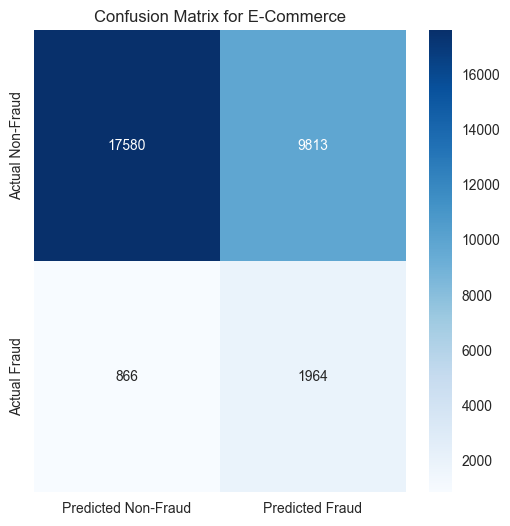

In [9]:
# --- Define and Train Logistic Regression Model ---

from sklearn.linear_model import LogisticRegression

# Define the model
logreg_ecommerce = LogisticRegression(max_iter=1000, random_state=42)

# Train on resampled (preprocessed) training data
logreg_ecommerce.fit(X_resampled_ecommerce, y_resampled_ecommerce)

# --- Transform Test Data Using the Pipeline ---

# Transform test data using the same preprocessing as training data
X_test_ecommerce_preprocessed = ecommerce_pipeline.named_steps['preprocessor'].transform(X_test_ecommerce)

# --- Make Predictions ---

# Now make predictions using the preprocessed test data
logreg_ecommerce_pred = logreg_ecommerce.predict(X_test_ecommerce_preprocessed)
logreg_ecommerce_proba = logreg_ecommerce.predict_proba(X_test_ecommerce_preprocessed)[:, 1]

# --- Evaluate the Model ---

# Evaluate
print("Logistic Regression Performance (E-Commerce):")
logreg_ecommerce_metrics = evaluate_model(y_test_ecommerce, logreg_ecommerce_pred, logreg_ecommerce_proba, "E-Commerce")

#### Train and Evaluate Random Forest

Random Forest Performance (E-Commerce):

Classification Report for E-Commerce:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.99      0.53      0.97      0.73      0.55     27393
          1       0.90      0.53      0.99      0.67      0.73      0.50      2830

avg / total       0.95      0.95      0.57      0.94      0.73      0.55     30223

ROC AUC Score: 0.7675
Precision-Recall AUC: 0.6214


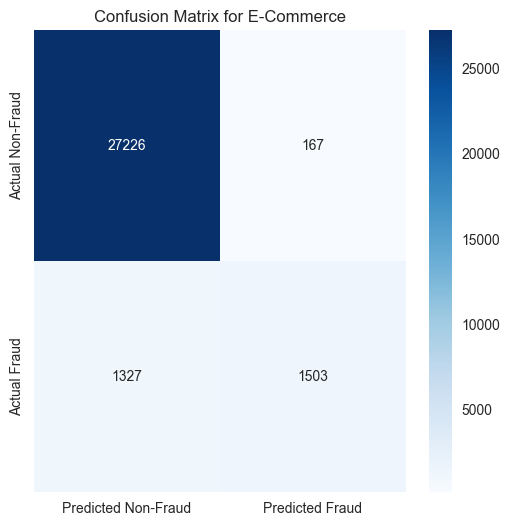

In [11]:
from sklearn.ensemble import RandomForestClassifier

# --- Define and Train Random Forest Model ---
# Define the model
rf_ecommerce = RandomForestClassifier(n_estimators=100, random_state=42)

# Train on resampled (preprocessed) training data
rf_ecommerce.fit(X_resampled_ecommerce, y_resampled_ecommerce)

# --- Transform Test Data Using the Pipeline ---
# Transform test data using the same preprocessing as training data
X_test_ecommerce_preprocessed = ecommerce_pipeline.named_steps['preprocessor'].transform(X_test_ecommerce)

# --- Make Predictions ---
# Now make predictions using the preprocessed test data
rf_ecommerce_pred = rf_ecommerce.predict(X_test_ecommerce_preprocessed)
rf_ecommerce_proba = rf_ecommerce.predict_proba(X_test_ecommerce_preprocessed)[:, 1]

# --- Evaluate the Model ---
print("Random Forest Performance (E-Commerce):")
rf_ecommerce_metrics = evaluate_model(y_test_ecommerce, rf_ecommerce_pred, rf_ecommerce_proba, "E-Commerce")

#### Repeat for Credit Card Data

Logistic Regression Performance (Credit Card):

Classification Report for Credit Card:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.98      0.91      0.99      0.94      0.90     56864
          1       0.08      0.91      0.98      0.14      0.94      0.88        98

avg / total       1.00      0.98      0.91      0.99      0.94      0.90     56962

ROC AUC Score: 0.9720
Precision-Recall AUC: 0.7777


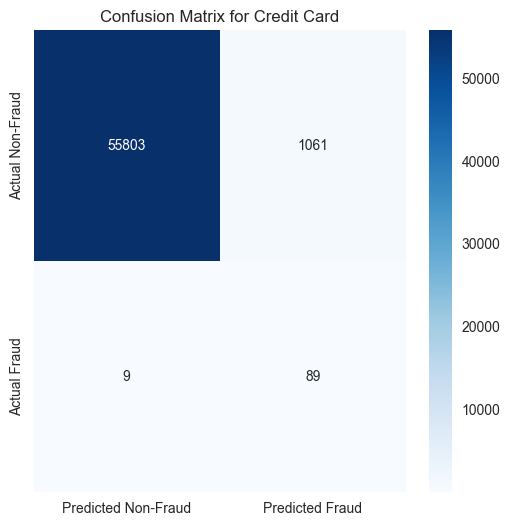

In [12]:
# Train Logistic Regression on credit card data
logreg_credit = LogisticRegression(max_iter=1000, random_state=42)
logreg_credit.fit(X_resampled_credit, y_resampled_credit)
logreg_credit_pred = logreg_credit.predict(X_test_credit)
logreg_credit_proba = logreg_credit.predict_proba(X_test_credit)[:, 1]

# Evaluate
print("Logistic Regression Performance (Credit Card):")
logreg_credit_metrics = evaluate_model(y_test_credit, logreg_credit_pred, logreg_credit_proba, "Credit Card")

Random Forest Performance (Credit Card):

Classification Report for Credit Card:
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.85      1.00      0.92      0.86     56864
          1       0.85      0.85      1.00      0.85      0.92      0.83        98

avg / total       1.00      1.00      0.85      1.00      0.92      0.86     56962

ROC AUC Score: 0.9680
Precision-Recall AUC: 0.8844


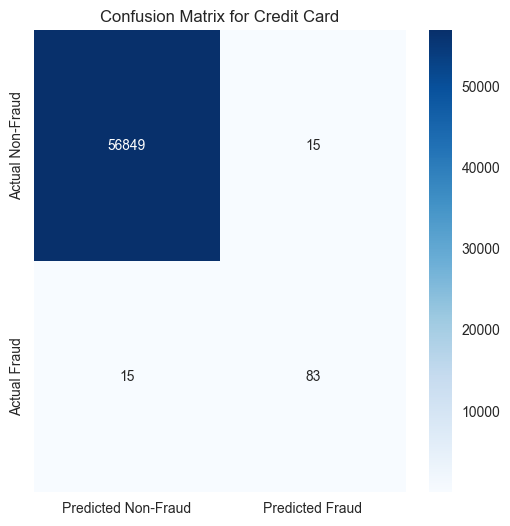

In [13]:
# Train Random Forest on credit card data
rf_credit = RandomForestClassifier(n_estimators=100, random_state=42)
rf_credit.fit(X_resampled_credit, y_resampled_credit)
rf_credit_pred = rf_credit.predict(X_test_credit)
rf_credit_proba = rf_credit.predict_proba(X_test_credit)[:, 1]

# Evaluate
print("Random Forest Performance (Credit Card):")
rf_credit_metrics = evaluate_model(y_test_credit, rf_credit_pred, rf_credit_proba, "Credit Card")

####  Visual Comparison

In [14]:
comparison_data = {
    'E-Commerce Logistic Regression': [logreg_ecommerce_metrics['roc_auc'], logreg_ecommerce_metrics['pr_auc']],
    'E-Commerce Random Forest': [rf_ecommerce_metrics['roc_auc'], rf_ecommerce_metrics['pr_auc']],
    'Credit Card Logistic Regression': [logreg_credit_metrics['roc_auc'], logreg_credit_metrics['pr_auc']],
    'Credit Card Random Forest': [rf_credit_metrics['roc_auc'], rf_credit_metrics['pr_auc']]
}

comparison_df = pd.DataFrame(comparison_data, index=['ROC AUC', 'PR AUC'])
print("Model Comparison:")
comparison_df

Model Comparison:


,E-Commerce Logistic Regression,E-Commerce Random Forest,Credit Card Logistic Regression,Credit Card Random Forest
ROC AUC,0.750983,0.767536,0.972011,0.968018
PR AUC,0.442613,0.621441,0.777678,0.884364
